<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/AL_with_CrisisMMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Project/multimodal_social_media

In [ ]:
pip install modal

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, metrics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import margin_sampling
from modAL.uncertainty import entropy_sampling

from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time

In [28]:
def load_data(filename, nb_instance):
  df = pd.read_csv(filename,sep="\t",nrows=nb_instance)
  df.label_image = pd.Categorical(df.label_image)
  df['label_image_code'] = df.label_image.cat.codes

  df[['image','label_image','label_image_code']]

  df.describe()
  return df

def pre_process_image(data):
  img_arr = []
  for index,row in data.iterrows():
    read_img = cv2.imread(row['image'],0)
    img_resize = cv2.resize(read_img,(224,224))
    img_ravel = img_resize.ravel()
    img_arr.append(img_ravel)

  img_np = np.array(img_arr)

  return img_np

def random_selection_learning(n_instances, X_train, y_train):
  clf = RandomForestClassifier()
  X_selected, X_non_selected, y_selected, y_non_selected = train_test_split(X_train,y_train,train_size=n_instances,shuffle=True)
  clf.fit(X_selected,y_selected)

  return clf, X_selected, X_non_selected, y_selected, y_non_selected

def evaluate(model, X_real, y_real):
  y_predictions = model.predict(X_real)
  accuracy = metrics.accuracy_score(y_predictions,y_real)

  return accuracy

def random_forest_score(n_initial,n_queries,sampling):
  start_time = time.time()
  acc_all = []
 
  for i in n_initial:
    
    initial_idx = np.random.choice(range(len(X_train)), size=i, replace=False)
    X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

    X_pool,y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
    
    learner = ActiveLearner(
            estimator=RandomForestClassifier(),
            query_strategy=sampling,
            X_training=X_initial,y_training=y_initial
            )
 
    for j in range(n_queries):
      res = [learner.score(X_test,y_test)]
      query_idx, query_inst = learner.query(X_pool)
      learner.teach(query_inst, y_pool[query_idx])
      X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)

    acc = learner.score(X_test,y_test)
    acc_all.append(acc)


  final_time = time.time() - start_time

  predictions = learner.predict(X_test)
  res_classification = classification_report(y_test, predictions)

  print("--- %s seconds ---" % (final_time))

  return res_classification, acc_all, final_time

In [20]:
n_initial = range(20,1000,100)
n_queries = 20

In [10]:
# Load CrisisMMD data

start_time = time.time()

train_instance = 9601
test_instance = 1534

train_filename = "data/task_data/task_informative_text_img_agreed_lab_train.tsv"
test_filename = "data/task_data/task_informative_text_img_agreed_lab_test.tsv"

data_train = load_data(train_filename,train_instance)
data_images_train = pre_process_image(data_train)

data_test = load_data(test_filename,test_instance)
data_image_test = pre_process_image(data_test)

X_train = data_images_train.reshape(train_instance,-1)
y_train = data_train['label_image_code'].values

X_test = data_image_test.reshape(test_instance,-1)
y_test = data_test['label_image_code'].values

final_time = time.time() - start_time
print("--- %s seconds ---" % (final_time))

--- 223.36646056175232 seconds ---


Train data distribution
Not Informative  3256
Informative  6345


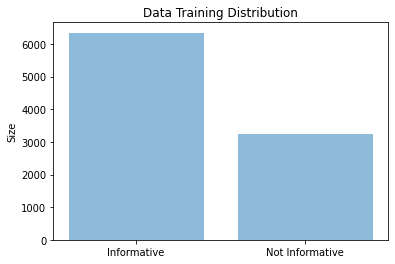

In [21]:
print("Train data distribution")

notinf_y_train = y_train[y_train == 1]
len_notinf = len(notinf_y_train)
print("Not Informative ",len_notinf)

inf_y_train = y_train[y_train == 0]
len_inf = len(inf_y_train)
print("Informative ",len_inf)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf,len_notinf]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Data Training Distribution')

plt.show()

Test data distribution
Not Informative  504
Informative  1030


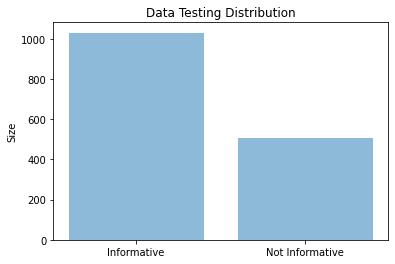

In [22]:
print("Test data distribution")

notinf_y_test = y_test[y_test == 1]
len_notinf_test = len(notinf_y_test)
print("Not Informative ",len_notinf_test)

inf_y_test = y_test[y_test == 0]
len_inf_test = len(inf_y_test)
print("Informative ",len_inf_test)

labels = ('Informative','Not Informative')
y_pos = np.arange(len(labels))

size = [len_inf_test,len_notinf_test]
plt.bar(y_pos,size,align='center',alpha=0.5)
plt.xticks(y_pos,labels)
plt.ylabel('Size')
plt.title('Data Testing Distribution')

plt.show()

In [29]:
result_rf_uncertainty, result_rf_acc_uncertainty, result_rf_time_uncertainty = random_forest_score(n_initial,n_queries,uncertainty_sampling)
print("Uncertainty : ")
print(result_rf_uncertainty)

result_rf_margin, result_rf_acc_margin, result_rf_time_margin = random_forest_score(n_initial,n_queries,margin_sampling)
print("Margin : ")
print(result_rf_margin)

result_rf_entropy, result_rf_acc_entropy, result_rf_time_entropy = random_forest_score(n_initial,n_queries,entropy_sampling)
print("Entropy : ")
print(result_rf_entropy)


--- 1513.8392980098724 seconds ---
Uncertainty : 
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1030
           1       0.65      0.29      0.40       504

    accuracy                           0.72      1534
   macro avg       0.69      0.61      0.61      1534
weighted avg       0.70      0.72      0.68      1534

--- 1494.2236573696136 seconds ---
Margin : 
              precision    recall  f1-score   support

           0       0.72      0.91      0.80      1030
           1       0.59      0.28      0.38       504

    accuracy                           0.70      1534
   macro avg       0.66      0.59      0.59      1534
weighted avg       0.68      0.70      0.66      1534

--- 1484.075514793396 seconds ---
Entropy : 
              precision    recall  f1-score   support

           0       0.72      0.92      0.80      1030
           1       0.61      0.27      0.37       504

    accuracy                           0.7

In [30]:
print(result_rf_acc_uncertainty)
print(result_rf_acc_margin)
print(result_rf_acc_entropy)

[0.7046936114732725, 0.7053455019556715, 0.6929595827900913, 0.7079530638852672, 0.6988265971316818, 0.7059973924380704, 0.6838331160365059, 0.7053455019556715, 0.7033898305084746, 0.7157757496740548]
[0.6460234680573663, 0.6694915254237288, 0.6701434159061278, 0.7079530638852672, 0.7066492829204694, 0.6936114732724902, 0.7066492829204694, 0.71251629726206, 0.7027379400260756, 0.7007822685788787]
[0.6590612777053455, 0.6831812255541069, 0.682529335071708, 0.6949152542372882, 0.6916558018252934, 0.6949152542372882, 0.711864406779661, 0.7073011734028684, 0.7046936114732725, 0.7020860495436767]


In [31]:
# Random sampling

def random_selection_learning(n_instances, X_train, y_train):
    clf = RandomForestClassifier()
   
    X_selected, X_not_selected, y_selec ted, y_not_selected = \
        train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)
    clf.fit(X_selected, y_selected)
    return clf, X_selected, X_not_selected, y_selected, y_not_selected

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    #print(f"{accuracy}")
    return accuracy

def learning_curve(data_points, repeats, selection_policy):
    start_time = time.time()
    experiments = []
    for i in tqdm(range(repeats)):
        np.random.seed(123)
        # First learn 
        n_samples = data_points[0]
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        acc_random = evaluate(model, X_test, y_test)
        experiments.append(acc_random)
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
      
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
      
            model.fit(X_selected, y_selected)
            acc_random = evaluate(model, X_test, y_test)
            experiments.append(acc_random)

    final_time = time.time() - start_time

    predictions = model.predict(X_test)
    res_classification = classification_report(y_test, predictions)

    print("--- %s seconds ---" % (final_time))
    return experiments, res_classification, final_time

n_initial = range(40,1000,100)
acc_random, res_random, time_random = learning_curve(n_initial,1, random_sampling_policy)


100%|██████████| 1/1 [01:08<00:00, 68.69s/it]

--- 68.69461441040039 seconds ---


In [32]:
print(res_random)

              precision    recall  f1-score   support

           0       0.72      0.91      0.80      1030
           1       0.59      0.28      0.38       504

    accuracy                           0.70      1534
   macro avg       0.66      0.59      0.59      1534
weighted avg       0.68      0.70      0.66      1534



Uncertainty avg:  0.7024119947848761
Margin avg:  0.6916558018252934
Entropy avg:  0.6932203389830509
Random avg:  0.6942633637548892


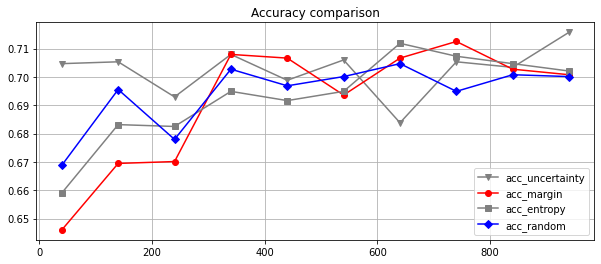

In [33]:
print("Uncertainty avg: ",np.mean(result_rf_acc_uncertainty))
print("Margin avg: ",np.mean(result_rf_acc_margin))
print("Entropy avg: ",np.mean(result_rf_acc_entropy))
print("Random avg: ",np.mean(acc_random))
df = pd.DataFrame({'x_values':n_initial,'acc_uncertainty':np.array(result_rf_acc_uncertainty),'acc_margin':np.array(result_rf_acc_margin),'acc_entropy':np.array(result_rf_acc_entropy),'acc_random':np.array(acc_random)})

width_height_1 = (10, 4)
plt.figure(figsize=width_height_1)

plt.plot('x_values','acc_uncertainty',data=df,color='gray',marker='v')
plt.plot('x_values','acc_margin',data=df,color='red',marker='o')
plt.plot('x_values','acc_entropy',data=df,color='gray',marker='s')
plt.plot('x_values','acc_random',data=df,color='blue',marker='D')
plt.title('Accuracy comparison')
plt.legend()
plt.grid()
plt.show()